# Prepare Data for Classification

In [501]:
from modules import *

In [502]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import missingno as msno

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

In [503]:
conn = dbConnect()
objects = dbTableToDataFrame(conn, 'cb_objects')
degrees = dbTableToDataFrame(conn, 'cb_degrees')
people = dbTableToDataFrame(conn, 'cb_people')
conn.close()

In this notebook I am going to prepare data to be analyzed in the classification notebook. The classification I will do is attempt to predict company succes, and find which categorical predictors about a company and founder, like company region or academic degree of the founder. Success here is based on status, with a status of "closed" for a company representing a failure for the company. This is an oversimplification of succes, but instead of looking at company value, I want to specifically run classificaiton models.

The predictors I am using are:
- company category_code
- whether they had funding (yes or no)
- whether they had investors (yes or no)
- number of relationships to other founders
- company logo height
- company logo width
- office latitude
- office longitude
- region
- degree_type (highest degree
- institution (for highest degree)
- subject (for highest degree
- first name
- last name

One big issue with this data set though is that it is mostly empty. Many of the variables have missing values in place of a "0", or for a categorical variable like 'closed_at', a none value means the company is not closed. This means if we don't create dumby variables the data frame will be almost entirely empty. Let's take a look at how empty our objects data frame is using missingno.

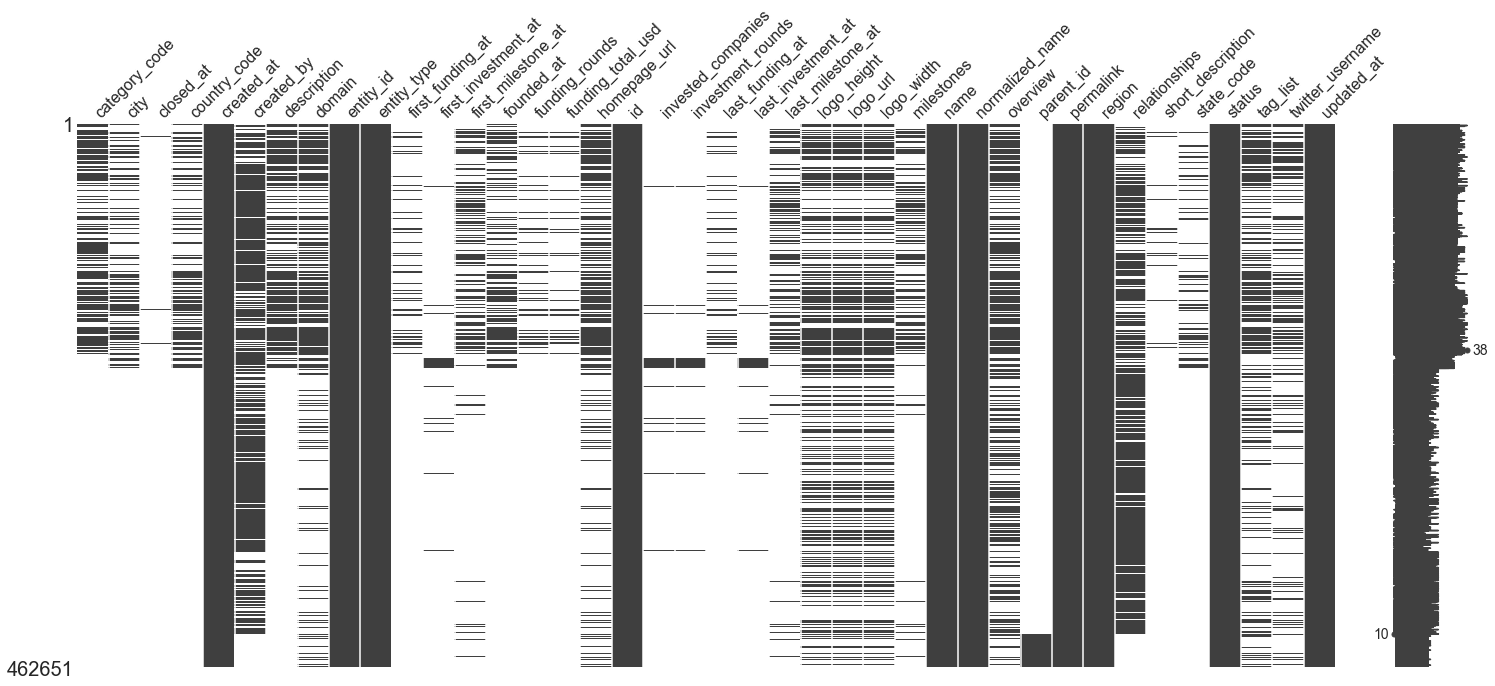

In [504]:
#look at missing values of objects
msno.matrix(objects)

The other issue is how we can go about combining the row of the data fame. We can look at the variable 'id' in object, and see every other data frame has an 'object_id'. At first, I thought this was great, and would let me combine any of the data frames. However, the 'id' in object or 'object_id' is different for founders and companies, and is denotated with a "p" for a person or "c" for company. Objects had information on everything, and seperates information for companies and founders This means I need to find a way to combine information about companies and their founders.

In [505]:
#in degrees and offices 'object_id' is matched to 'id' in objects
#I am going to create an 'object_id' in objects
ids = objects['id'].values
objects['object_id'] = ids

I am not starting with all variables as predictors for a couple of reasons. For one, I want to avoid multicollinearity issues. Many of the variables are hightly correlated, which is why for now I am only using region, instead of state and country as well. These specific variables were chosen because they are largely categorical, and don't deal directly with the company's total funding or worth. I am now going to create some dumby variables to get rid of the emptiness of the data.

In [506]:
#function to convert into dumnby variables
def convert_dumby(column, df, positive, negative, pos_val = False):
    """
    description: create a two class dummby variable for a dataframe with None values
    
    inputs:
        column: String, must be name of column in df
        df: Pandas Data Frame
        postive: String/Boolean/Integer, what to call non-none value in dumby variable
        negative: String/Boolean/Integer, what to call non value in dumby variable
        pos_val: Boolean (optional), if True then positive keep their own value
        
    output:
        dumby vector
    """
    if type(column) != str:
        raise ValueError("column and newname must be a string")
    if type(df) != pd.core.frame.DataFrame:
        raise ValueError("df must be pandas data frame")
    col = df[column]
    bools = col.isnull().values
    if pos_val == True:
        dumby = []
        for i in range(len(bools)):
            if bools[i] == True:
                dumby.append(negative)
            else:
                dumby.append(col.values[i])
        return(dumby)
    dumby = [positive if not status else negative for status in bools]
    return(dumby)

In [507]:
#make dumby variables of responses:
closed = convert_dumby('closed_at', objects, 'Yes', 'No', False)
objects['closed'] = closed

In [508]:
#make dumby variable for funding: Yes if they got funding, no if not
funding = convert_dumby('first_funding_at', objects, 'Yes', 'No')
objects['had_funding'] = funding

In [509]:
#make dumby variable for investment: Yes if they got investment, no if not
investment = convert_dumby('invested_companies', objects, 'Yes', 'No')
objects['has_investment'] = investment

In [510]:
#get number of relationships
num_relationships = convert_dumby('relationships', objects, 'Yes', 0.0, pos_val = True)
objects['num_relationships'] = num_relationships

In [511]:
#get number of milestones
num_milestones = convert_dumby('milestones', objects, 'Yes', 0.0, pos_val = True)
objects['num_milestones'] = num_milestones

In [512]:
#deal with people that didn't go to school for subjects
subjects = convert_dumby('subject', degrees, 'Yes', 'None', pos_val = True)
degrees['subjects'] = subjects

In [513]:
#deal with institution for people that didn't go to school
school = convert_dumby('institution', degrees, 'Yes', 'None', pos_val = True)
degrees['school'] = school

In [514]:
#deal with degree for people that didn't get a degree
degree = convert_dumby('degree_type', degrees, 'Yes', 'None', pos_val = True)
degrees['degree'] = degree

In [515]:
#deal with logo sizes
width = convert_dumby('logo_width', objects, 'Yes', 0.0, pos_val = True)
objects['logo_width'] = width

height = convert_dumby('logo_height', objects, 'Yes', 0.0, pos_val = True)
objects['logo_height'] = height

Now I can store the predictors in one data frame.

In [516]:
def keep_variables(df, variables, object_id = True):
    """
    description: create a two class dummby variable for a dataframe with None values
    
    inputs:
        df: Pandas Data Frame from where columns are selected
        variables: a list of strings of column names of variables to select
        object_id: (optional) boolean variable, if False do not keep object_id, else add object_id to variables
        
    output:
        Pandas Data Frame of variables we want to keep
    """
    #check inputs are good
    if type(variables) != list:
        raise TypeError("variables must be a list of strings")
    if not all(isinstance(item, str) for item in variables):
        raise ValueError("all items in variables must be strings")
    if type(df) != pd.core.frame.DataFrame:
        raise ValueError("df must be pandas data frame")
    if object_id:
        variables = ['object_id'] + variables
    return df[variables]

In [517]:
#keep variables from people
people['name'] = people['affiliation_name']
vars_people = keep_variables(people, ['birthplace', 'first_name', 'last_name', 'name'])
vars_people.head()

,object_id,birthplace,first_name,last_name,name
0,p:2,None,Ben,Elowitz,Blue Nile
1,p:3,None,Kevin,Flaherty,Wetpaint
2,p:4,None,Raju,Vegesna,Zoho
3,p:5,None,Ian,Wenig,Zoho
4,p:6,"Redding, CA",Kevin,Rose,i/o Ventures


In [518]:
#keep variables from degrees
vars_degrees = keep_variables(degrees, ['degree_type', 'institution', 'subject'])
vars_degrees.head()

,object_id,degree_type,institution,subject
0,p:6117,MBA,None,None
1,p:6136,BA,"Washington University, St. Louis","English, French"
2,p:6136,MS,Boston University,Mass Communication
3,p:6005,MS,University of Greenwich,Internet Technology
4,p:5832,BCS,Rice University,"Computer Science, Psychology"


In [519]:
#keep variables from objects
vars_objects = keep_variables(objects, ['closed', 'status', 'name', 'category_code', 'had_funding', 'has_investment', 'num_relationships', 'num_milestones', 'logo_height', 'logo_width', 'region'])
vars_objects.head()

,object_id,closed,status,name,category_code,had_funding,has_investment,num_relationships,num_milestones,logo_height,logo_width,region
0,c:1,No,operating,Wetpaint,web,Yes,No,17.0,5.0,54.0,401.0,Seattle
1,c:10,No,acquired,Flektor,games_video,No,No,6.0,0.0,85.0,186.0,Los Angeles
2,c:100,No,acquired,There,games_video,No,No,12.0,4.0,34.0,107.0,SF Bay
3,c:10000,No,operating,MYWEBBO,network_hosting,No,No,0.0,0.0,0.0,0.0,unknown
4,c:10001,No,operating,THE Movie Streamer,games_video,No,No,0.0,0.0,74.0,200.0,unknown


In [520]:
def drop_duplicates(dfs_info):
    """
    description: create a two class dummby variable for a dataframe with None values
    
    inputs:
        dfs_info: List tuples. First item is data frame, second is subset info for drop_dublic, last is keep infor for drop_duplicate 
        
    output:
        list of pandas dfs equal to length of list
    """
    dfs = []
    for item in dfs_info:
        cur_df = item[0]
        cur_subset = item[1]
        cur_keep = item[2]
        edit_df = cur_df.drop_duplicates(subset = cur_subset, keep = cur_keep)
        dfs.append(edit_df)
    return(dfs)

In [521]:
#set up function
first = (vars_people, 'name', 'first')
second = (vars_degrees, 'object_id', 'last')
dfs_info = [first, second]

#edit dfs
vs = drop_duplicates(dfs_info)
vars_people = vs[0]
vars_degrees = vs[1]

In [522]:
def multi_merge(dfs, times, on = 'object_id', leave_out = []):
    """
    description: merge multiple data frame
    
    inputs:
        dfs: List of Pandas Data Frame to be merged
        times: number of seperate merges
        on: (optional) String, column to be merged on
        leave_out: (optional) list of 2 item tuples. Each tuple's first item is a data frame from the df list and the second item is a list of columns to leave out of merge.
        
    output:
        Pandas Data Frame of meged dfs
    """
    if type(dfs) != list:
        raise TypeError("dfs must be a list of Pandas dfs")
    if not all(isinstance(item, pd.core.frame.DataFrame) for item in dfs):
        raise ValueError("all items in dfs must be Pandas DFs")
        
    if len(leave_out) != 0:
        if type(leave_out) is not list or not all(isinstance(t, tuple) for t in leave_out):
            raise TypeError("leave_out must be a list of tuples")
        for item in leave_out:
            df_to_alter = item[0]
            cols = item[1]
            if df_to_alter not in dfs:
                raise ValueError("data frams in leave_out must be in multi_merge")
            df_alterted = df_to_alter.drop(cols, 1)
            index = dfs.index(df_to_alter)
            dfs[index] = df_alterted
            
    first = dfs[0]
    rest = dfs[1:]
    for i in range(len(rest)):
        cur_df = rest[i]
        first = first.merge(cur_df, on = on)
    return(first)

In [523]:
#merge the data frames
deg_pep = vars_degrees.merge(vars_people, on = 'object_id')

#drop object id
#df1 = obj_off.drop('object_id', 1)
df1 = vars_objects.drop('object_id', 1)
df2 = deg_pep.drop('object_id', 1)

dat = df1.merge(df2, on = 'name')
dat.shape

(14051, 17)

In [524]:
#replace missing value
rep_na = dat.replace("", np.nan)
rep_na = rep_na.replace('unkown', np.nan)

We still have an issue in that much of this data will have completely empty rows. I am going to deal with this by droping any row that has na values.

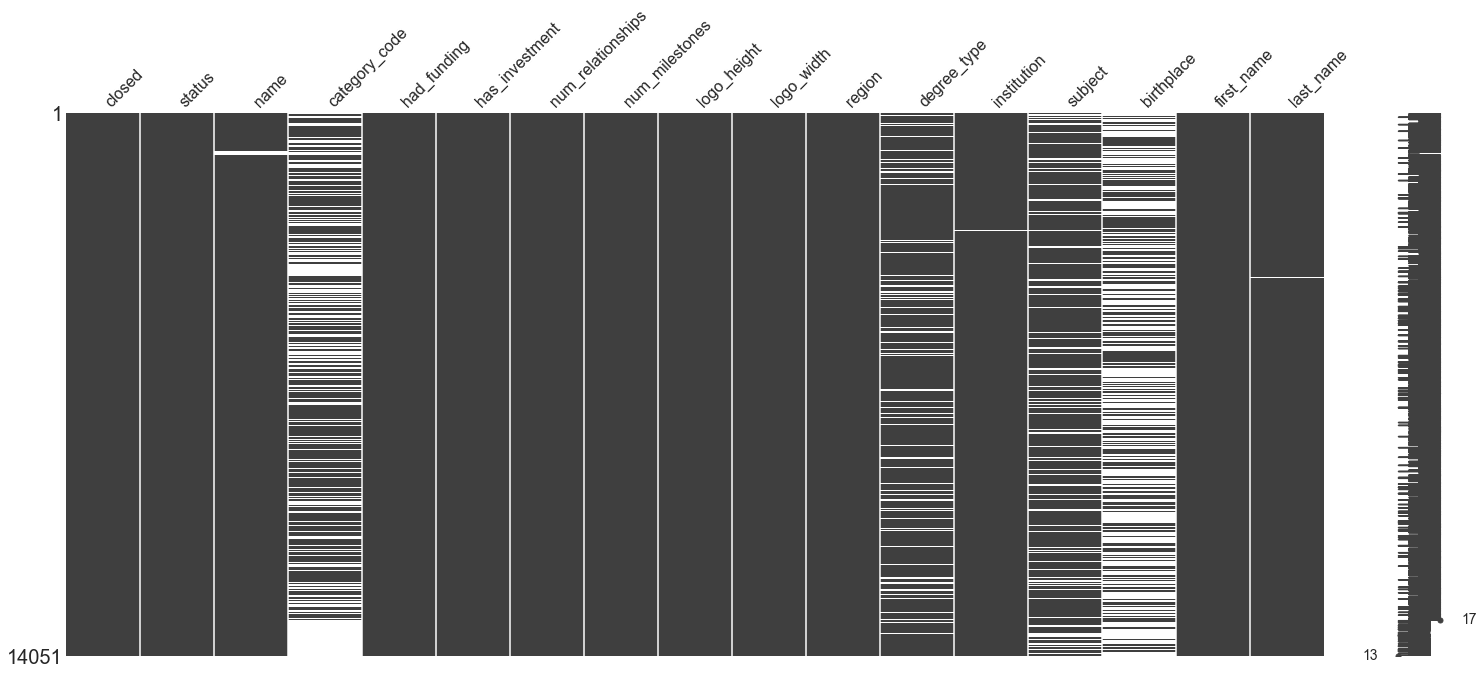

In [525]:
#look at emptiness of data
msno.matrix(rep_na)

In [526]:
data = rep_na.dropna(axis = 0, how = 'any')
data.shape

(2827, 17)

In [527]:
data.head()

,closed,status,name,category_code,had_funding,has_investment,num_relationships,num_milestones,logo_height,logo_width,region,degree_type,institution,subject,birthplace,first_name,last_name
7,No,operating,Fundable.com,finance,No,Yes,3.0,4.0,120.0,120.0,Columbus,BBA,Ohio State University,"Entrepreneurship, Marketing",Ohio,Eric,Corl
8,No,operating,Wevod,games_video,Yes,No,2.0,0.0,89.0,250.0,Paris,MS,EPITECH,computer sciences and technologies,France,Nassim,Ghandour
11,No,acquired,Jumptap,mobile,Yes,No,45.0,3.0,165.0,650.0,Boston,BA,American University,Economics,"St. Petersburg, Russia",Veronika,Sonsev
18,Yes,closed,FairSoftware,web,Yes,No,1.0,1.0,67.0,250.0,SF Bay,MS,Supelec,Electrical Engineering,"Paris, France",Alain,Raynaud
22,No,operating,WPP,public_relations,No,Yes,23.0,3.0,59.0,86.0,New York,Degree,University of Kentucky,Degree,Kentucky,Jack,Smith


Now I can safe the data file and use it in the next notebook

In [528]:
#save data
data.to_hdf('results/classification_data.h5', 'classification_data')